# Projekt: Lokalizacja punktu w przestrzeni dwuwymiarowej – Metoda Separatorów
**Autor:** Gabriel
**Przedmiot:** Algorytmy Geometryczne

## 1. Wstęp Teoretyczny
[cite_start]Problem lokalizacji punktu polega na znalezieniu regionu $R_i$ w podziale płaszczyzny, który zawiera dany punkt zapytania $p$[cite: 13]. W tym projekcie prezentujemy **Metodę Łańcuchów (Chain Method)**, znaną również jako metoda separatorów.

### Główne założenia metody:
1.  **Monotoniczność:** Podział płaszczyzny składa się z obszarów monotonicznych. [cite_start]Jeśli obszary nie są monotoniczne, wymagana jest regularyzacja (np. triangulacja)[cite: 104].
2.  [cite_start]**Separatory (Łańcuchy):** Konstruujemy zbiór łańcuchów monotonicznych, które uporządkowują obszary od lewej do prawej[cite: 14].

[cite_start]Struktura danych to drzewo binarne, gdzie węzły reprezentują łańcuchy, a liście reprezentują regiony[cite: 30]. Zapytanie o punkt polega na dyskryminacji (porównaniu) położenia punktu względem kolejnych łańcuchów w drzewie, co pozwala na osiągnięcie logarytmicznego czasu zapytania.


In [2]:
import math
import random
from typing import List , Tuple , Optional , Union , Any
from functools import cmp_to_key
import matplotlib as plt
import numpy as np
import pandas as pd
from bitalg.visualizer.main import Visualizer
from time import time
import os

In [3]:
TOLERANCE = 1e-24

# Data Structures

class Vertex:
    def __init__(self, x_coord: float, y_coord: float):
        self.x = x_coord
        self.y = y_coord
        self.adj_out: List[Tuple['Vertex', int]] = []
        self.adj_in: List[Tuple['Vertex', int]] = []
        self.accumulated_weight_in = 0
        self.accumulated_weight_out = 0

    @property
    def coords(self) -> Tuple[float, float]:
        return self.x, self.y

    def __repr__(self):
        return f"V({self.x:.2f}, {self.y:.2f})"

class MonotoneChain:
    def __init__(self):
        self.path_vertices: List[Tuple[float, float]] = []
        self.path_segments: List[Tuple[Tuple[float, float], Tuple[float, float]]] = []

    def add_node(self, coords: Tuple[float, float]):
        self.path_vertices.append(coords)

    def add_segment(self, start: Tuple[float, float], end: Tuple[float, float]):
        self.path_segments.append((start, end))

class SearchTreeNode:
    def __init__(self, segments: List, chain_ref: MonotoneChain, parent: Optional['SearchTreeNode'] = None):
        self.left_child: Optional[SearchTreeNode] = None
        self.right_child: Optional[SearchTreeNode] = None
        self.parent = parent
        self.segments = segments
        self.chain_ref = chain_ref

## 2. Przetwarzanie Grafu i Wagi Planarne
Aby zbudować drzewo łańcuchów, musimy najpierw odpowiednio skierować krawędzie i nadać im wagi. Algorytm wykonuje dwa przejścia:
1.  **Forward pass:** Propagacja wag z dołu do góry.
2.  **Backward pass:** Korekta wag z góry na dół.

[cite_start]Celem jest ustalenie przepływu tak, aby każdy łańcuch mógł zostać wyodrębniony jako ścieżka monotoniczna od źródła do ujścia grafu[cite: 33].

In [4]:
# Geometry Utils

def cross_product(o: Tuple[float, float], a: Tuple[float, float], b: Tuple[float, float]) -> float:
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

# Graph Processing

def build_graph(raw_vertices: List[Tuple[float, float]], raw_edges: List[Tuple[int, int]]) -> List[Vertex]:
    graph_nodes = [Vertex(x, y) for x, y in raw_vertices]
    for start_idx, end_idx in raw_edges:
        # Ensure edges point upwards (or rightwards for equal Y) to maintain DAG property
        u, v = sorted((start_idx, end_idx))
        node_u = graph_nodes[u]
        node_v = graph_nodes[v]
        node_u.adj_out.append((node_v, 1))
        node_v.adj_in.append((node_u, 1))
    return graph_nodes

def compute_planar_weights(graph: List[Vertex]):
    for node in graph:
        center = node.coords
        
        # Sort edges angularly to identify "leftmost" and "rightmost" paths
        def angular_comparator(edge1, edge2):
            p1 = edge1[0].coords
            p2 = edge2[0].coords
            cp = cross_product(center, p1, p2)
            if math.isclose(cp, 0, abs_tol=TOLERANCE): return 0
            return -1 if cp > 0 else 1

        node.adj_out.sort(key=cmp_to_key(angular_comparator))
        node.adj_in.sort(key=cmp_to_key(lambda a, b: -1 * angular_comparator(a, b)))

    # Forward pass: Propagate weights from bottom to top
    for i in range(1, len(graph) - 1):
        v = graph[i]
        v.accumulated_weight_in = sum(w for _, w in v.adj_in)
        v.accumulated_weight_out = len(v.adj_out)
        
        # if input flow > output flow, push excess to leftmost outgoing edge
        if v.accumulated_weight_in > v.accumulated_weight_out:
            target_node, current_w = v.adj_out.pop(0)
            new_weight = current_w + v.accumulated_weight_in - v.accumulated_weight_out
            v.adj_out.insert(0, (target_node, new_weight))
            
            # Update the corresponding incoming edge at the target node
            for idx, (neighbor, w) in enumerate(target_node.adj_in):
                if neighbor == v:
                    target_node.adj_in[idx] = (v, new_weight)
                    break

    # Backward pass: Propagate weights from top to bottom
    for i in range(len(graph) - 2, 0, -1):
        v = graph[i]
        v.accumulated_weight_in = sum(w for _, w in v.adj_in)
        v.accumulated_weight_out = sum(w for _, w in v.adj_out)
        
        # If output flow > input flow, pull excess from leftmost incoming edge
        if v.accumulated_weight_out > v.accumulated_weight_in:
            source_node, current_w = v.adj_in.pop(0)
            new_weight = current_w + v.accumulated_weight_out - v.accumulated_weight_in
            v.adj_in.insert(0, (source_node, new_weight))
            
            for idx, (neighbor, w) in enumerate(source_node.adj_out):
                if neighbor == v:
                    source_node.adj_out[idx] = (v, new_weight)
                    break

## 3. Generowanie Łańcuchów Monotonicznych i Struktura Wyszukiwania
Algorytm zachłannie buduje łańcuchy, "konsumując" wagi krawędzi. Powstałe łańcuchy są następnie organizowane w zbalansowane drzewo poszukiwań binarnego (BST).

* **Liście drzewa:** Odpowiadają regionom.
[cite_start]* **Węzły wewnętrzne:** Odpowiadają łańcuchom (separatorom)[cite: 31].
Drzewo to pozwala na szybkie określenie, po której stronie separatora znajduje się punkt.

In [5]:
def generate_monotone_chains(graph: List[Vertex]) -> List[MonotoneChain]:
    source_node = graph[0]
    total_chains = sum(w for _, w in source_node.adj_out)
    chains = [MonotoneChain() for _ in range(total_chains)]
    
    for chain in chains:
        current_v = source_node
        
        # Traverse graph greedily consuming edge weights
        while current_v.adj_out:
            chain.add_node(current_v.coords)
            chosen_idx = -1
            
            # Pick the rightmost available edge (non-zero weight)
            for i in range(len(current_v.adj_out) - 1, -1, -1):
                neighbor, weight = current_v.adj_out[i]
                if weight > 0:
                    chosen_idx = i
                    break
            if chosen_idx == -1: break
            
            next_v, w = current_v.adj_out[chosen_idx]
            current_v.adj_out[chosen_idx] = (next_v, w - 1) # Decrease capacity
            current_v = next_v
            
        chain.add_node(current_v.coords)
        
        verts = chain.path_vertices
        for k in range(len(verts) - 1):
            chain.add_segment(verts[k], verts[k+1])
    return chains

def create_search_structure(chains: List[MonotoneChain], parent: Optional[SearchTreeNode] = None) -> Optional[SearchTreeNode]:
    if not chains: return None
    mid_idx = len(chains) // 2
    median_chain = chains[mid_idx]
    
    node = SearchTreeNode(median_chain.path_segments, median_chain, parent)
    node.left_child = create_search_structure(chains[:mid_idx], node)
    node.right_child = create_search_structure(chains[mid_idx + 1:], node)
    return node

## 4. Logika Zapytania (Point Location)
Dla zadanego punktu $p$ algorytm schodzi w dół drzewa. W każdym węźle sprawdzamy relację punktu względem separatora:
* Jeśli punkt jest na lewo od separatora -> idziemy do lewego dziecka.
[cite_start]* Jeśli punkt jest na prawo od separatora -> idziemy do prawego dziecka [cite: 49-50].

Test relacji wykorzystuje iloczyn wektorowy (`cross_product`) oraz wyszukiwanie binarne na segmentach separatora.

In [6]:
# Query Logic

def find_position_relative_to_chain(point: Tuple[float, float], node: SearchTreeNode) -> int:
    px, py = point
    segments = node.segments
    target_segment = None
    
    # Binary Search to find the segment covering the point's Y-coordinate
    left_idx, right_idx = 0, len(segments) - 1
    
    while left_idx <= right_idx:
        mid_idx = (left_idx + right_idx) // 2
        p1, p2 = segments[mid_idx]
        
        y_min, y_max = p1[1], p2[1]
        
        if y_min - TOLERANCE <= py <= y_max + TOLERANCE:
            target_segment = (p1, p2)
            break
        elif py < y_min:
            right_idx = mid_idx - 1
        else:
            left_idx = mid_idx + 1
            
    if target_segment is None: 
        return 1
    
    cp = cross_product(target_segment[0], target_segment[1], point)
    
    if math.isclose(cp, 0, abs_tol=TOLERANCE):
        # Handle collinear points: check if strictly inside segment bounds
        min_x = min(target_segment[0][0], target_segment[1][0])
        max_x = max(target_segment[0][0], target_segment[1][0])
        if min_x <= px <= max_x:
            return 0 
        return -1 if px > target_segment[0][0] else 1
    
    # Return -1 for Right, 1 for Left
    return -1 if cp < 0 else 1

def query_search_tree(point: Tuple[float, float], node: Optional[SearchTreeNode], 
                     closest_left: Optional[MonotoneChain] = None,
                     closest_right: Optional[MonotoneChain] = None) -> Union[MonotoneChain, Tuple[MonotoneChain, MonotoneChain]]:
    if node is None:
        return (closest_left, closest_right)
        
    position = find_position_relative_to_chain(point, node)
    
    if position == 0:
        return node.chain_ref
        
    # Traverse BST based on point position relative to current separator
    if position < 0:
        return query_search_tree(point, node.right_child, closest_left=node.chain_ref, closest_right=closest_right)
    else: 
        return query_search_tree(point, node.left_child, closest_left=closest_left, closest_right=node.chain_ref)

def extract_region_edges(chain_a: MonotoneChain, chain_b: MonotoneChain, point: Tuple[float, float]) -> List[Tuple]:
    if chain_a is None: return chain_b.path_segments 
    if chain_b is None: return chain_a.path_segments

    verts_a = chain_a.path_vertices
    verts_b = chain_b.path_vertices
    
    bubbles = []
    i, j = 0, 0
    last_common_a_idx = 0
    last_common_b_idx = 0
    
    # Iterate through both chains to find split and merge points ("bubbles")
    while i < len(verts_a) and j < len(verts_b):
        va = verts_a[i]
        vb = verts_b[j]
        
        is_same = math.isclose(va[0], vb[0], abs_tol=TOLERANCE) and math.isclose(va[1], vb[1], abs_tol=TOLERANCE)
        
        if is_same:
            if i > last_common_a_idx or j > last_common_b_idx:
                # Close the bubble and store it
                bubble_a = verts_a[last_common_a_idx : i+1]
                bubble_b = verts_b[last_common_b_idx : j+1]
                bubbles.append((bubble_a, bubble_b))
                
            last_common_a_idx = i
            last_common_b_idx = j
            i += 1
            j += 1
        else:
            # Advance pointer for the geometrically lower vertex
            if va[1] < vb[1] or (math.isclose(va[1], vb[1]) and va[0] < vb[0]):
                i += 1
            else:
                j += 1
                
    py = point[1]
    result_edges = []
    
    # Find which bubble contains the query point Y-coordinate
    for path_a, path_b in bubbles:
        min_y = min(v[1] for v in path_a + path_b)
        max_y = max(v[1] for v in path_a + path_b)
        
        if min_y <= py <= max_y:
            # Collect unique edges from both sides of the bubble
            for k in range(len(path_a) - 1):
                result_edges.append((path_a[k], path_a[k+1]))
            for k in range(len(path_b) - 1):
                edge = (path_b[k], path_b[k+1])
                if edge not in result_edges:
                    result_edges.append(edge)
            if result_edges:
                return result_edges

    return result_edges

# Main API

def run_point_location(vertices: List[Tuple[float, float]], edges: List[Tuple[int, int]], query_point: Tuple[float, float]):
    graph = build_graph(vertices, edges)
    compute_planar_weights(graph)
    separators = generate_monotone_chains(graph)
    bst_root = create_search_structure(separators)
    
    result = query_search_tree(query_point, bst_root, closest_left=separators[0], closest_right=separators[-1])
    
    # Handle point exactly on a separator
    if isinstance(result, MonotoneChain):
        segments = result.path_segments
        l, r = 0, len(segments) - 1
        while l <= r:
            mid = (l + r) // 2
            seg = segments[mid]
            if seg[0][1] <= query_point[1] <= seg[1][1]:
                return [seg]
            elif query_point[1] < seg[0][1]:
                r = mid - 1
            else:
                l = mid + 1
        return result.path_segments
        
    # Handle point inside a region
    sep_left, sep_right = result
    return extract_region_edges(sep_left, sep_right, query_point)

In [7]:
def separators_method_point_location_algorithm_visualiser(raw_vertices, raw_edges, point):
    try:
        from bitalg.visualizer.main import Visualizer
    except ImportError:
        return None, run_point_location(raw_vertices, raw_edges, point)

    vis = Visualizer()
    vis.add_point(raw_vertices, color="black")
    
    segments = []
    for u, v in raw_edges:
        p1 = raw_vertices[u]
        p2 = raw_vertices[v]
        segments.append((p1, p2))
    vis.add_line_segment(segments, color="gray")
    
    found_edges = run_point_location(raw_vertices, raw_edges, point)
    
    vis.add_point(point, color="green")
    if found_edges:
        vis.add_line_segment(found_edges, color="red", linewidth=3)
        
    return vis, found_edges

def animate_point_location(raw_vertices: List[Tuple[float, float]], 
                           raw_edges: List[Tuple[int, int]], 
                           query_point: Tuple[float, float]):
    """
    Tworzy animację (GIF) działania algorytmu lokalizacji punktu.
    """
    try:
        from bitalg.visualizer.main import Visualizer
    except ImportError:
        print("Brak biblioteki bitalg.")
        return None

    # 1. Building structures
    graph = build_graph(raw_vertices, raw_edges)
    compute_planar_weights(graph)
    separators = generate_monotone_chains(graph)
    bst_root = create_search_structure(separators)
    
    # 2. Visualizer
    vis = Visualizer()
    
    # drawing input graph
    vis.add_point(raw_vertices, color="black", s=5)
    
    all_segments = []
    for u, v in raw_edges:
        p1 = raw_vertices[u]
        p2 = raw_vertices[v]
        all_segments.append((p1, p2))
    vis.add_line_segment(all_segments, color="lightgray", linewidth=1)
    
    # query point
    vis.add_point([query_point], color="green", s=20)
    
    # 3. animation loop
    current_node = bst_root
    
    while current_node is not None:
        # A. show current separator
        chain_segments = current_node.segments
        chain_fig = vis.add_line_segment(chain_segments, color="orange", linewidth=2)
        
        # B. find segment on separator what alligns with query point, using binsearch
        px, py = query_point
        target_segment = None
        left_idx, right_idx = 0, len(chain_segments) - 1
        
        while left_idx <= right_idx:
            mid_idx = (left_idx + right_idx) // 2
            p1, p2 = chain_segments[mid_idx]
            y_min, y_max = p1[1], p2[1]
            
            if y_min - TOLERANCE <= py <= y_max + TOLERANCE:
                target_segment = (p1, p2)
                break
            elif py < y_min:
                right_idx = mid_idx - 1
            else:
                left_idx = mid_idx + 1
        
        seg_fig = None
        position = 1 # default case

        if target_segment:
            # C. show curretn segment
            seg_fig = vis.add_line_segment([target_segment], color="blue", linewidth=4)
            
            # calculate position
            cp = cross_product(target_segment[0], target_segment[1], query_point)
            if math.isclose(cp, 0, abs_tol=TOLERANCE):
                position = 0 # collinear
            else:
                position = -1 if cp < 0 else 1
        
        # D. deeting figure for animation
        if seg_fig:
            vis.remove_figure(seg_fig)
        
        vis.remove_figure(chain_fig)
        
        # E. traversing BST
        if position == 0:
            break # collinear
        elif position < 0:
            current_node = current_node.right_child
        else:
            current_node = current_node.left_child

    # 4. show final polygon
    found_edges = run_point_location(raw_vertices, raw_edges, query_point)
    if found_edges:
        vis.add_line_segment(found_edges, color="red", linewidth=3)
        
    return vis

## 5. Obsługa Dowolnych Wielokątów (Pre-processing)
Ponieważ metoda łańcuchów wymaga regionów monotonicznych, dowolne wielokąty (w tym wklęsłe) muszą zostać poddane obróbce. Stosujemy tutaj metodę **Ear Clipping** do triangulacji wielokątów.

[cite_start]Powstały graf trójkątów może być niespójny (zawierać "wyspy"), dlatego funkcja `patch_graph_connectivity` dodaje wirtualne krawędzie łączące, tworząc spójny graf wymagany przez algorytm[cite: 104].

In [8]:
import math

# WORK IN PROGRESS

def cross_product(o, a, b):
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

def is_point_in_triangle(p, a, b, c):
    cp1 = cross_product(a, b, p)
    cp2 = cross_product(b, c, p)
    cp3 = cross_product(c, a, p)
    has_neg = (cp1 < 0) or (cp2 < 0) or (cp3 < 0)
    has_pos = (cp1 > 0) or (cp2 > 0) or (cp3 > 0)
    return not (has_neg and has_pos)

def get_polygon_signed_area(points):
    area = 0.0
    for i in range(len(points)):
        j = (i + 1) % len(points)
        area += points[i][0] * points[j][1]
        area -= points[j][0] * points[i][1]
    return area / 2.0

def triangulate_indices(indices, vertices):
    local_indices = indices[:]
    triangles = []
    n = len(local_indices)
    max_iter = n * n 
    count = 0
    
    while len(local_indices) > 2:
        if count > max_iter:
            break
        n_curr = len(local_indices)
        ear_found = False
        for i in range(n_curr):
            prev_idx = local_indices[(i - 1) % n_curr]
            curr_idx = local_indices[i]
            next_idx = local_indices[(i + 1) % n_curr]
            
            p_prev = vertices[prev_idx]
            p_curr = vertices[curr_idx]
            p_next = vertices[next_idx]
            
            if cross_product(p_prev, p_curr, p_next) > 0.0000001:
                is_ear = True
                for k in range(n_curr):
                    test_idx = local_indices[k]
                    if test_idx in (prev_idx, curr_idx, next_idx): continue
                    if is_point_in_triangle(vertices[test_idx], p_prev, p_curr, p_next):
                        is_ear = False
                        break
                if is_ear:
                    triangles.append((prev_idx, curr_idx, next_idx))
                    local_indices.pop(i)
                    ear_found = True
                    break
        if not ear_found: local_indices.pop(0)
        count += 1
    return triangles

def process_polygons_to_mesh(polygons_list):
    """
    Tworzy siatkę, a na końcu sortuje wierzchołki rosnąco po Y (i X dla stabilności)
    oraz aktualizuje indeksy krawędzi.
    """
    temp_vertices = []
    vertex_map = {} 
    all_edges = set() 
    
    def get_vertex_index(pt):
        pt_tuple = (round(pt[0], 6), round(pt[1], 6))
        if pt_tuple not in vertex_map:
            vertex_map[pt_tuple] = len(temp_vertices)
            temp_vertices.append(pt_tuple)
        return vertex_map[pt_tuple]

    for poly in polygons_list:
        if len(poly) < 3: continue
        poly_indices = [get_vertex_index(p) for p in poly]
        
        original_coords = [temp_vertices[i] for i in poly_indices]
        if get_polygon_signed_area(original_coords) < 0:
            poly_indices.reverse()
            
        tris = triangulate_indices(poly_indices, temp_vertices)
        
        for (i1, i2, i3) in tris:
            all_edges.add(tuple(sorted((i1, i2))))
            all_edges.add(tuple(sorted((i2, i3))))
            all_edges.add(tuple(sorted((i3, i1))))

    indexed_vertices = list(enumerate(temp_vertices))
    
    indexed_vertices.sort(key=lambda x: (x[1][1], x[1][0]))
    
    sorted_vertices = []
    old_to_new_map = {}
    
    for new_idx, (old_idx, pt) in enumerate(indexed_vertices):
        sorted_vertices.append(pt)
        old_to_new_map[old_idx] = new_idx
        
    final_edges = []
    for u, v in all_edges:
        new_u = old_to_new_map[u]
        new_v = old_to_new_map[v]
        final_edges.append(tuple(sorted((new_u, new_v))))
        
    final_edges.sort()

    return sorted_vertices, final_edges

In [9]:
def manual_delaunay_generator(width=10, height=10, num_points=15):
    # generates random points and edges
    vertices = []
    # adding corners
    vertices.extend([(0.0, 0.0), (float(width), 0.0), (0.0, float(height)), (float(width), float(height))])
    
    # random points
    for _ in range(num_points):
        x = random.uniform(0.1, width - 0.1)
        y = random.uniform(0.1, height - 0.1)
        vertices.append((x, y))

    # triangulization
    n = len(vertices)
    edges = set()

    # checking every tree points
    for i in range(n):
        for j in range(i + 1, n):
            for k in range(j + 1, n):
                x1, y1 = vertices[i]
                x2, y2 = vertices[j]
                x3, y3 = vertices[k]

                # det
                D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
                
                # if points are collinear
                if abs(D) < 1e-5: continue
                
                # srodek okregu opisanego
                Ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
                Uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
                
                r_sq = (Ux - x1)**2 + (Uy - y1)**2
                center = (Ux, Uy)
                
                # Warunek Delaunaya
                is_valid = True
                for m in range(n):
                    if m == i or m == j or m == k: continue
                    dist_sq = (vertices[m][0] - center[0])**2 + (vertices[m][1] - center[1])**2
                    
                    if dist_sq < r_sq - 1e-5:
                        is_valid = False
                        break
                
                if is_valid:
                    edges.add(tuple(sorted((i, j))))
                    edges.add(tuple(sorted((j, k))))
                    edges.add(tuple(sorted((k, i))))

    edge_list = list(edges)

    # fallback
    if len(edge_list) == 0:
        print("  [INFO] Triangulacja zwróciła 0 krawędzi. Używam fallbacku.")
        for i in range(len(vertices) - 1):
            edge_list.append((i, i+1))
        # close loop
        edge_list.append((len(vertices)-1, 0))

    return vertices, edge_list, 0

## 6. Przykłady i Testy


In [66]:
Tests = [
    [[(np.float64(15.483870967741936), np.float64(9.415584415584416)), (np.float64(80.3225806451613), np.float64(9.577922077922079)), (np.float64(79.83870967741936), np.float64(47.72727272727273)), (np.float64(22.903225806451612), np.float64(63.63636363636363)), (np.float64(72.74193548387098), np.float64(84.74025974025975)), (np.float64(6.129032258064516), np.float64(90.9090909090909))],
    [(3, 4), (2, 3), (2, 4), (1, 2), (0, 1), (0, 2), (0, 5), (3, 5), (0, 3), (4, 5)]],
    [[(np.float64(96.29032258064517), np.float64(16.233766233766236)), (np.float64(3.548387096774192), np.float64(21.753246753246756)), (np.float64(17.419354838709676), np.float64(36.201298701298704)), (np.float64(91.45161290322581), np.float64(37.66233766233766)), (np.float64(61.61290322580645), np.float64(41.55844155844156)), (np.float64(93.70967741935483), np.float64(66.88311688311688)), (np.float64(16.451612903225804), np.float64(70.61688311688312)), (np.float64(5.0), np.float64(78.4090909090909)), (np.float64(43.064516129032256), np.float64(78.57142857142858)), (np.float64(15.161290322580644), np.float64(88.3116883116883)), (np.float64(89.6774193548387), np.float64(90.25974025974025))],
    [(9, 10), (8, 10), (8, 9), (5, 8), (5, 10), (3, 8), (3, 5), (4, 8), (2, 4), (2, 6), (6, 8), (7, 9), (6, 7), (3, 4), (1, 2), (0, 1), (0, 4), (0, 3), (1, 7)]],
    [[(np.float64(91.7741935483871), np.float64(7.305194805194805)), (np.float64(7.096774193548388), np.float64(9.253246753246753)), (np.float64(22.903225806451612), np.float64(24.51298701298701)), (np.float64(71.7741935483871), np.float64(27.272727272727273)), (np.float64(65.48387096774194), np.float64(60.714285714285715)), (np.float64(22.903225806451612), np.float64(62.17532467532468)), (np.float64(81.93548387096774), np.float64(92.53246753246754)), (np.float64(8.225806451612904), np.float64(94.48051948051949))],
    [(6, 7), (1, 7), (0, 1), (0, 6), (5, 7), (4, 5), (4, 6), (1, 2), (2, 5), (2, 3), (0, 3), (3, 4)]],
]

names = ['t1', 't2', 't3']

for i in range(len(Tests)):
    P, E = Tests[i]
    POINT = (25, 25)
    vis, _ = separators_method_point_location_algorithm_visualiser(P, E, POINT)
    vis.save( names[i] + "img")
    vis = animate_point_location(P, E, POINT)
    vis.save_gif(names[i] + "gif")



In [61]:

POINT = (20, 20)

P =  [(np.float64(18.709677419354836), np.float64(6.493506493506494)), (np.float64(84.6774193548387), np.float64(14.61038961038961)), (np.float64(68.70967741935485), np.float64(31.33116883116883)), (np.float64(41.77419354838709), np.float64(48.37662337662338)), (np.float64(53.70967741935485), np.float64(77.1103896103896)), (np.float64(18.548387096774196), np.float64(83.11688311688312)), (np.float64(84.35483870967742), np.float64(89.77272727272728))]
E =  [(5, 6), (1, 6), (0, 1), (0, 5), (0, 3), (3, 5), (3, 4), (4, 5), (4, 6), (2, 4), (2, 6), (1, 2), (2, 3), (0, 2)]
Pol =  [[(np.float64(18.548387096774196), np.float64(83.11688311688312)), (np.float64(84.35483870967742), np.float64(89.77272727272728)), (np.float64(84.6774193548387), np.float64(14.61038961038961)), (np.float64(18.709677419354836), np.float64(6.493506493506494))], [(np.float64(18.709677419354836), np.float64(6.493506493506494)), (np.float64(41.77419354838709), np.float64(48.37662337662338)), (np.float64(18.548387096774196), np.float64(83.11688311688312))], [(np.float64(41.77419354838709), np.float64(48.37662337662338)), (np.float64(53.70967741935485), np.float64(77.1103896103896)), (np.float64(18.548387096774196), np.float64(83.11688311688312))], [(np.float64(53.70967741935485), np.float64(77.1103896103896)), (np.float64(18.548387096774196), np.float64(83.11688311688312)), (np.float64(84.35483870967742), np.float64(89.77272727272728))], [(np.float64(53.70967741935485), np.float64(77.1103896103896)), (np.float64(68.70967741935485), np.float64(31.33116883116883)), (np.float64(84.35483870967742), np.float64(89.77272727272728))], [(np.float64(68.70967741935485), np.float64(31.33116883116883)), (np.float64(84.6774193548387), np.float64(14.61038961038961)), (np.float64(84.35483870967742), np.float64(89.77272727272728))], [(np.float64(41.77419354838709), np.float64(48.37662337662338)), (np.float64(68.70967741935485), np.float64(31.33116883116883)), (np.float64(53.70967741935485), np.float64(77.1103896103896))], [(np.float64(18.709677419354836), np.float64(6.493506493506494)), (np.float64(68.70967741935485), np.float64(31.33116883116883)), (np.float64(41.77419354838709), np.float64(48.37662337662338))]]
Pol =  [[(np.float64(36.935483870967744), np.float64(82.79220779220779)), (np.float64(17.580645161290324), np.float64(29.383116883116884)), (np.float64(68.54838709677419), np.float64(26.13636363636364))], [(np.float64(36.935483870967744), np.float64(82.79220779220779)), (np.float64(73.87096774193549), np.float64(94.48051948051949)), (np.float64(68.54838709677419), np.float64(26.13636363636364))], [(np.float64(68.54838709677419), np.float64(26.13636363636364)), (np.float64(59.83870967741936), np.float64(8.116883116883116)), (np.float64(17.580645161290324), np.float64(29.383116883116884))], [(np.float64(17.580645161290324), np.float64(29.383116883116884)), (np.float64(52.25806451612904), np.float64(34.41558441558442)), (np.float64(43.70967741935483), np.float64(57.46753246753247)), (np.float64(30.64516129032258), np.float64(52.75974025974026))]]
P, E = process_polygons_to_mesh(Pol)

# Próba wizualizacji dla przetworzonych danych
try:
    vis_, e_ = separators_method_point_location_algorithm_visualiser(P, E, POINT)
    vis_.show()
    vis = animate_point_location(P, E, POINT)
    vis.save_gif("gif")
    
except Exception as e:
    print(f"Wystąpił błąd podczas wizualizacji: {e}")

Wystąpił błąd podczas wizualizacji: pop from empty list


In [11]:
def generate_tri_grid(width, height):
    vertices = []
    edges = []
    for y in range(height + 1):
        for x in range(width + 1):
            vertices.append((float(x), float(y)))
    def get_idx(x, y):
        return y * (width + 1) + x
    for y in range(height):
        for x in range(width):
            u = get_idx(x, y)
            right = get_idx(x + 1, y)
            top = get_idx(x, y + 1)
            top_right = get_idx(x + 1, y + 1)
            edges.append((u, right))
            edges.append((u, top))
            edges.append((right, top_right))
            edges.append((top, top_right))
            edges.append((u, top_right))
    unique_edges = set()
    for u, v in edges:
        if u < v: unique_edges.add((u, v))
        else: unique_edges.add((v, u))
    return vertices, list(unique_edges), 0

def generate_quad_grid(width, height, skew=0.0):
    vertices = []
    edges = []
    for y in range(height + 1):
        shift = y * skew
        for x in range(width + 1):
            vertices.append((float(x + shift), float(y)))
    def get_idx(x, y):
        return y * (width + 1) + x
    for y in range(height + 1):
        for x in range(width):
            u = get_idx(x, y)
            v = get_idx(x + 1, y)
            edges.append((u, v))
    for x in range(width + 1):
        for y in range(height):
            u = get_idx(x, y)
            v = get_idx(x, y + 1)
            edges.append((u, v))
    unique_edges = set()
    for u, v in edges:
        if u < v: unique_edges.add((u, v))
        else: unique_edges.add((v, u))
    return vertices, list(unique_edges), skew

# Scenariusze Testowe
scenarios = [
    {"gen": lambda: manual_delaunay_generator(width=10, height=10, num_points=30), 
        "dims": (10, 10),
        "desc": "Nieregularny (Własna Triangulacja)"},
    {"gen": lambda: generate_quad_grid(3, 3, skew=0.0), "dims": (3, 3), "desc": "Siatka 3x3 (Kwadraty)"},
    {"gen": lambda: generate_quad_grid(4, 2, skew=0.5), "dims": (4, 2), "desc": "Siatka 4x2 (Równoległoboki)"},
    {"gen": lambda: generate_tri_grid(2, 5), "dims": (2, 5), "desc": "Siatka 2x5 (Trójkąty)"},
]

output_folder = "gif"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print("Rozpoczynam generowanie animacji...")
for s_idx, scen in enumerate(scenarios):
    desc = scen["desc"]
    w, h = scen["dims"]
    print(f"\n--- Przetwarzanie scenariusza {s_idx}: {desc} ---")
    vertices, edges, skew = scen["gen"]()
    points_to_check = []
    for _ in range(2):
        py = random.uniform(0, h)
        shift_at_y = py * skew 
        px = random.uniform(0 + shift_at_y, w + shift_at_y)
        points_to_check.append((px, py))
        
    for p_idx, point in enumerate(points_to_check):
        try:
            vis_anim = animate_point_location(vertices, edges, point)
            if vis_anim:
                filename = f"scenariusz_{s_idx:02d}_punkt_{p_idx}.gif"
                full_path = os.path.join(output_folder, filename)
                vis_anim.save_gif(full_path)
                print(f"    -> Zapisano: {full_path}")
        except Exception as e:
            print(f"    [BŁĄD]: {e}")
            


Rozpoczynam generowanie animacji...

--- Przetwarzanie scenariusza 0: Nieregularny (Własna Triangulacja) ---
    [BŁĄD]: pop from empty list
    [BŁĄD]: pop from empty list

--- Przetwarzanie scenariusza 1: Siatka 3x3 (Kwadraty) ---
    -> Zapisano: gif\scenariusz_01_punkt_0.gif
    -> Zapisano: gif\scenariusz_01_punkt_1.gif

--- Przetwarzanie scenariusza 2: Siatka 4x2 (Równoległoboki) ---
    -> Zapisano: gif\scenariusz_02_punkt_0.gif
    -> Zapisano: gif\scenariusz_02_punkt_1.gif

--- Przetwarzanie scenariusza 3: Siatka 2x5 (Trójkąty) ---
    -> Zapisano: gif\scenariusz_03_punkt_0.gif
    -> Zapisano: gif\scenariusz_03_punkt_1.gif


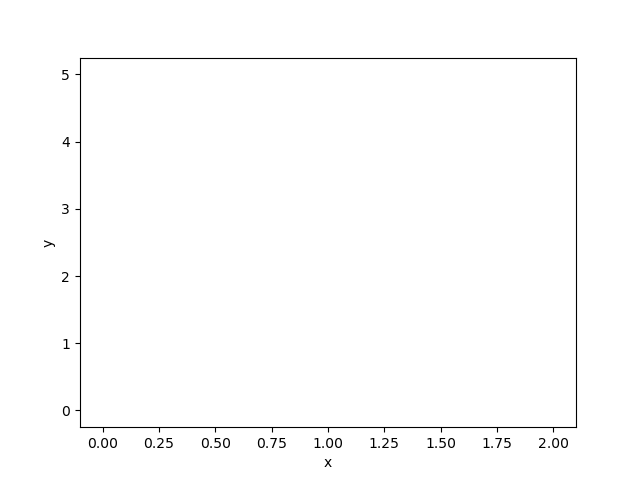

In [13]:
P, E, _ = generate_quad_grid(2, 5)
point = (0.5, 4)
vis = animate_point_location(P, E, point)
vis.show_gif()


## 7. Dodatki (Analiza i Input)


In [63]:
def generate_large_procedural_graph(rows, cols):
    """
    Generuje duży, poprawny graf planarny w formie siatki trójkątów.
    Zwraca (vertices, edges).

    Liczba wierzchołków V = rows * cols
    """
    vertices = []
    edges = []

    # 1. Generowanie wierzchołków (V)
    # Dodajemy mały losowy 'jitter', żeby punkty nie były idealnie w linii (bardziej realistyczne)
    for y in range(rows):
        for x in range(cols):
            jitter_x = random.uniform(-0.2, 0.2)
            jitter_y = random.uniform(-0.2, 0.2)
            vertices.append((float(x) + jitter_x, float(y) + jitter_y))

    # pomoc do pobierania indeksu w liście jednowymiarowej
    def get_idx(c, r):
        return r * cols + c

    # 2. Generowanie krawędzi (E) - łączenie z sąsiadami (prawo, góra, góra-prawo)
    for r in range(rows - 1):
        for c in range(cols - 1):
            curr = get_idx(c, r)
            right = get_idx(c + 1, r)
            top = get_idx(c, r + 1)
            top_right = get_idx(c + 1, r + 1) # Przekątna

            # Krawędź pozioma
            edges.append((curr, right))
            # Krawędź pionowa
            edges.append((curr, top))
            # Krawędź ukośna (tworzy trójkąty)
            edges.append((curr, top_right))

            # Domknięcie krawędzi na brzegach siatki (dla estetyki, opcjonalne)
            if c == cols - 2: # Ostatnia kolumna, krawędzie pionowe
                edges.append((right, top_right))

        # Ostatni rząd, krawędzie poziome
        for c in range(cols - 1):
            bottom_last = get_idx(c, rows - 1)
            bottom_right_last = get_idx(c + 1, rows - 1)
            edges.append((bottom_last, bottom_right_last))

    return vertices, edges

In [64]:
grid_sizes = [10, 50, 100, 150, 200, 400] #, 600]
result_list = []
ReportsDir = "Reports/"

test_configs = [
    ('TriGrid', generate_tri_grid),
    ('QuadGrid', generate_quad_grid)
]

for type_name, generator_func in test_configs:
    print(f"Rozpoczynam benchmark dla: {type_name}")

    for N in grid_sizes:
        # 1. Generowanie danych (używamy generatora z obecnej konfiguracji)
        # Zakładam, że oba generatory zwracają (vertices, edges, _)
        vertices, edges, _ = generator_func(N, N)
        setNum = len(vertices)

        # --- POMIAR CZASU BUDOWY ---
        t0 = time()
        try:
            graph = build_graph(vertices, edges)
            compute_planar_weights(graph)
            separators = generate_monotone_chains(graph)
            bst_root = create_search_structure(separators)
            build_time = time() - t0

            # --- POMIAR CZASU ZAPYTANIA ---
            query_count = 100
            test_points = [(random.uniform(0, N), random.uniform(0, N)) for _ in range(query_count)]

            t1 = time()
            for p in test_points:
                # query_search_tree używa bst_root i skrajnych separatorów
                query_search_tree(p, bst_root, closest_left=separators[0], closest_right=separators[-1])
            query_time_total = time() - t1
            avg_query_time = query_time_total / query_count

            # Dodanie do listy wyników
            result_list.append({
                'Typ Grafu': type_name,
                'Liczba V': setNum,
                'Liczba E': len(edges),
                'Czas Budowy [s]': build_time,
                'Czas Zapytania [s]': avg_query_time
            })
            print(f"  Zakończono dla V={setNum}")

        except Exception as e:
            print(f"  Błąd podczas przetwarzania {type_name} dla V={setNum}: {e}")

# Tworzenie DataFrame i zapis
final_dataframe = pd.DataFrame(result_list)
print("\nWyniki końcowe:")
print(final_dataframe)

# Zapis do CSV (nadpisze poprzedni plik lub stworzy nowy)
if not os.path.exists(ReportsDir):
    os.makedirs(ReportsDir)

final_dataframe.to_csv(ReportsDir + 'Benchmark_Separatory_Full.csv', index=False)

Rozpoczynam benchmark dla: TriGrid
  Zakończono dla V=121
  Zakończono dla V=2601
  Zakończono dla V=10201
  Zakończono dla V=22801
  Zakończono dla V=40401
  Zakończono dla V=160801
Rozpoczynam benchmark dla: QuadGrid
  Zakończono dla V=121
  Zakończono dla V=2601
  Zakończono dla V=10201
  Zakończono dla V=22801
  Zakończono dla V=40401
  Zakończono dla V=160801

Wyniki końcowe:
   Typ Grafu  Liczba V  Liczba E  Czas Budowy [s]  Czas Zapytania [s]
0    TriGrid       121       320         0.169191            0.000014
1    TriGrid      2601      7600         0.057865            0.000040
2    TriGrid     10201     30200         4.547816            0.000024
3    TriGrid     22801     67800         0.951596            0.000030
4    TriGrid     40401    120400         1.498787            0.000038
5    TriGrid    160801    480800         7.008073            0.000064
6   QuadGrid       121       220         0.004012            0.000008
7   QuadGrid      2601      5100         0.138088       

In [ ]:
# Lista rozmiarów siatek (NxN), dla których robimy benchmark
grid_sizes = [10, 50, 100, 150, 200, 400 , 600 ]#, 1000 ]#, 10000]
result_list = []

ReportsDir = "Reports/"

for N in grid_sizes:
    # 1. Generowanie danych (Tri Grid)
    # V = N*N, E ≈ 3*N*N
    vertices, edges, _ = generate_tri_grid(N, N)
    setNum = len(vertices)

    # --- POMIAR CZASU BUDOWY ---
    t0 = time()
    graph = build_graph(vertices, edges)
    compute_planar_weights(graph)
    separators = generate_monotone_chains(graph)
    bst_root = create_search_structure(separators)
    build_time = time() - t0

    # --- POMIAR CZASU ZAPYTANIA ---
    # Wykonujemy 100 zapytań, aby uśrednić wynik dla bardzo małych czasów
    query_count = 100
    test_points = [(random.uniform(0, N), random.uniform(0, N)) for _ in range(query_count)]

    t1 = time()
    for p in test_points:
        query_search_tree(p, bst_root, closest_left=separators[0], closest_right=separators[-1])
    query_time_total = time() - t1
    avg_query_time = query_time_total / query_count

    # Dodanie do listy w Twoim stylu
    result_list.append({
        'Liczba V': setNum,
        'Liczba E': len(edges),
        'Czas Budowy [s]': build_time,
        'Czas Zapytania [s]': avg_query_time,
        'Typ Grafu': 'TriGrid'
    })

# Tworzenie DataFrame i zapis
final_dataframe = pd.DataFrame(result_list)
print(final_dataframe)

# Zapis do CSV
final_dataframe.to_csv(ReportsDir + 'Benchmark_Separatory.csv', index=False)

   Liczba V  Liczba E  Czas Budowy [s]  Czas Zapytania [s] Typ Grafu
0       121       320         0.006279            0.000022   TriGrid
1      2601      7600         0.071486            0.000021   TriGrid
2     10201     30200         0.997894            0.000061   TriGrid
3     22801     67800         0.936604            0.000052   TriGrid
4     40401    120400         1.317816            0.000065   TriGrid
5    160801    480800         6.653133            0.000047   TriGrid
6    361201   1081200        16.949869            0.000052   TriGrid
